# Car Price Prediction

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV
import warnings
warnings.filterwarnings('ignore')

In [87]:
pd.options.plotting.backend = "matplotlib"

In [27]:
df=pd.read_csv("cleaned final car dataset")

In [28]:
df.sample(6)

,Unnamed: 0,name,price,Location,Fuel type,Transmission,Kms driven,year,Company Name
3048,3048,Verna SX (O),"10,17,499",Bengaluru,Petrol,manual,"30,646",2017,Hyundai
1624,1624,i20 Asta (O),"6,24,837",Mumbai,Petrol,manual,"51,525",2017,Hyundai
2213,2213,Glanza G,"8,07,499",Pune,Petrol,automatic,"21,288",2019,Toyota
2388,2388,EcoSport Titanium + Ti-VCT,"11,09,542",Pune,Petrol,manual,"6,934",2020,Ford
454,454,Creta E Plus,"9,05,039",Delhi,Diesel,manual,"53,502",2018,Hyundai
4304,4304,A4 2.0 TDI 177 Bhp Technology Edition,"17,99,999",Hyderabad,Diesel,automatic,"71,000",2014,Audi


In [29]:
df.columns

Index(['Unnamed: 0', 'name', 'price', 'Location', 'Fuel type', 'Transmission',
       'Kms driven', 'year', 'Company Name'],
      dtype='object')

In [30]:
df.shape

(5169, 9)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    5169 non-null   int64 
 1   name          5169 non-null   object
 2   price         5169 non-null   object
 3   Location      5169 non-null   object
 4   Fuel type     5169 non-null   object
 5   Transmission  5162 non-null   object
 6   Kms driven    5169 non-null   object
 7   year          5169 non-null   int64 
 8   Company Name  5169 non-null   object
dtypes: int64(2), object(7)
memory usage: 363.6+ KB


In [32]:
df.isnull().sum()

Unnamed: 0      0
name            0
price           0
Location        0
Fuel type       0
Transmission    7
Kms driven      0
year            0
Company Name    0
dtype: int64

In [33]:
df.describe(include='all')

,Unnamed: 0,name,price,Location,Fuel type,Transmission,Kms driven,year,Company Name
count,5169.000000,5169,5169,5169,5169,5162,5169,5169.000000,5169
unique,NaN,1348,3571,6,5,5,4157,NaN,29
top,NaN,Wagon R VXi,"4,50,000",Pune,Petrol,manual,"1,20,000",NaN,Maruti
freq,NaN,101,57,999,3360,4160,46,NaN,1822
mean,2584.000000,NaN,NaN,NaN,NaN,NaN,NaN,2015.521377,NaN
std,1492.306101,NaN,NaN,NaN,NaN,NaN,NaN,3.018707,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1981.000000,NaN
25%,1292.000000,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,NaN
50%,2584.000000,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,NaN
75%,3876.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN


Observations:
   - 7 null values are present in Transmission, which we can impute with mode
   - we need to convert the dtype of some columns to int or float as they are recorded as strings
   - we can drop the index column, its useless in terms
   - Some outliers are present

### Data Preprocessing:

In [34]:
for i in range(len(df["price"])):
    df["price"][i]= df["price"][i].replace(",","")
    df["Kms driven"][i]= df["Kms driven"][i].replace(",","")
df

,Unnamed: 0,name,price,Location,Fuel type,Transmission,Kms driven,year,Company Name
0,0,Creta E,664999,Delhi,Petrol,manual,40224,2016,Hyundai
1,1,Wagon R LXi,343954,Delhi,CNG,manual,68557,2017,Maruti
2,2,Creta S,707999,Delhi,Petrol,manual,70447,2015,Hyundai
3,3,Swift VDi,230449,Delhi,Diesel,manual,88658,2012,Maruti
4,4,Kwid RXT,228751,Delhi,Petrol,manual,30606,2016,Renault
...,...,...,...,...,...,...,...,...,...
5164,5164,SX4 ZXI MT BSIV,271000,Pune,Petrol,manual,63000,2011,Maruti
5165,5165,New Laura 1.8 TSI Ambiente,325000,Pune,Petrol,manual,79000,2011,Skoda
5166,5166,Grand i10 Magna,460000,Pune,Petrol,manual,71234,2017,Hyundai
5167,5167,Nano Twist XT,145000,Pune,Petrol,manual,18070,2014,Tata


In [40]:
df['Kms driven'] = df['Kms driven'].astype(int)
df['price'] = df['price'].astype(int)

In [41]:
df.dtypes

Unnamed: 0       int64
name            object
price            int32
Location        object
Fuel type       object
Transmission    object
Kms driven       int32
year             int64
Company Name    object
dtype: object

In [53]:
df.drop("Unnamed: 0",inplace=True,axis=1)

In [57]:
df.sample(5)

,name,price,Location,Fuel type,Transmission,Kms driven,year,Company Name
4578,Ertiga ZDI,725000,Pune,Diesel,manual,46811,2014,Maruti
3305,Grand i10 1.2 Kappa Asta,625000,Chennai,Petrol,manual,14000,2019,Hyundai
4283,Polo GT TSI,890000,Hyderabad,Petrol,automatic,73440,2018,Volkswagen
3178,Nexon 1.2 Revotron XMA,854850,Chennai,Petrol,automatic,12000,2019,Tata
303,WR-V VX,855464,Delhi,Diesel,manual,39405,2018,Honda


In [58]:
df.describe(include='all')

,name,price,Location,Fuel type,Transmission,Kms driven,year,Company Name
count,5169,5.169000e+03,5169,5169,5162,5169.000000,5169.000000,5169
unique,1348,NaN,6,5,5,NaN,NaN,29
top,Wagon R VXi,NaN,Pune,Petrol,manual,NaN,NaN,Maruti
freq,101,NaN,999,3360,4160,NaN,NaN,1822
mean,NaN,6.355737e+05,NaN,NaN,NaN,51049.301025,2015.521377,NaN
std,NaN,5.048332e+05,NaN,NaN,NaN,31291.365449,3.018707,NaN
min,NaN,1.250000e+04,NaN,NaN,NaN,586.000000,1981.000000,NaN
25%,NaN,3.920000e+05,NaN,NaN,NaN,28383.000000,2014.000000,NaN
50%,NaN,5.350290e+05,NaN,NaN,NaN,47000.000000,2016.000000,NaN
75%,NaN,7.347360e+05,NaN,NaN,NaN,69002.000000,2018.000000,NaN


In [60]:
for i in df.columns[2:]:
    print(df[i].value_counts(),"\n")

Pune         999
Chennai      934
Delhi        869
Hyderabad    836
Mumbai       776
Bengaluru    755
Name: Location, dtype: int64 

Petrol               3360
Diesel               1741
CNG                    55
Electric(Battery)       8
LPG                     5
Name: Fuel type, dtype: int64 

manual                 4160
automatic               778
Amt                     133
Cvt                      90
automatic - 5 Gears       1
Name: Transmission, dtype: int64 

120000    46
80000     39
60000     39
70000     37
50000     33
          ..
62239      1
64290      1
21283      1
95124      1
14333      1
Name: Kms driven, Length: 4124, dtype: int64 

2016    766
2017    766
2018    690
2015    612
2014    522
2019    478
2013    352
2012    265
2020    189
2011    177
2010    117
2008     58
2009     53
2021     48
2007     35
2004     10
2006     10
2005      8
2003      4
2002      3
2001      2
1981      2
1995      1
1998      1
Name: year, dtype: int64 

Maruti           1822
Hyu

In [68]:
df["Transmission"]=df["Transmission"].fillna(df["Transmission"].mode()[0])

In [69]:
df["Transmission"].isnull().sum()

0

In [109]:
for i in range(len(df["Company Name"])):
    df["Company Name"][i]=df["Company Name"][i].replace("Land","Land Rover")

# EDA:

In [71]:
df.dtypes

name            object
price            int32
Location        object
Fuel type       object
Transmission    object
Kms driven       int32
year             int64
Company Name    object
dtype: object

In [96]:
num_feat=["price","Kms driven"]
cat_feat=["name","Location","year","Fuel type","Transmission","Company Name"]

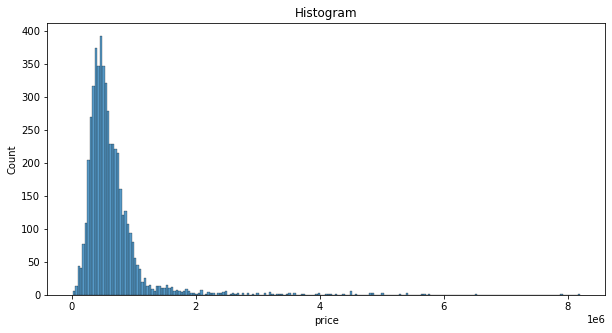

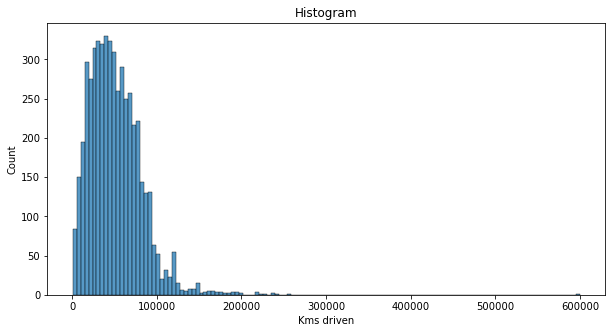

In [78]:
for i in num_feat:
    plt.figure(figsize=(10,5))
    sns.histplot(df[i],palette="viridis")
    plt.title("Histogram")
    plt.show()

Observations:
- Majority of the price is centered around 500,000 
- Maximum distance driven by cars hovers around 45000 km

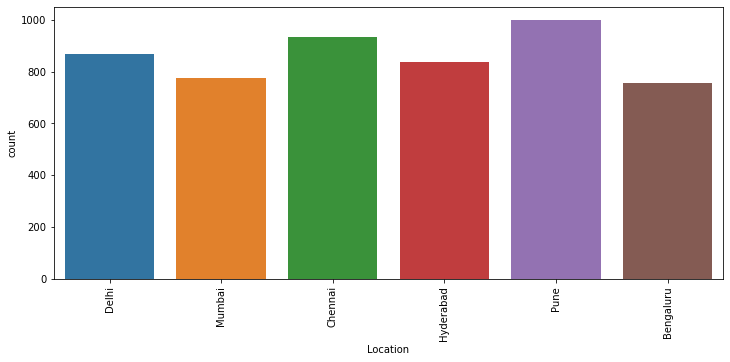

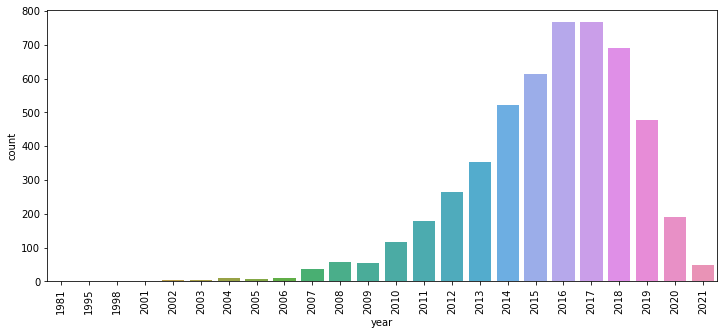

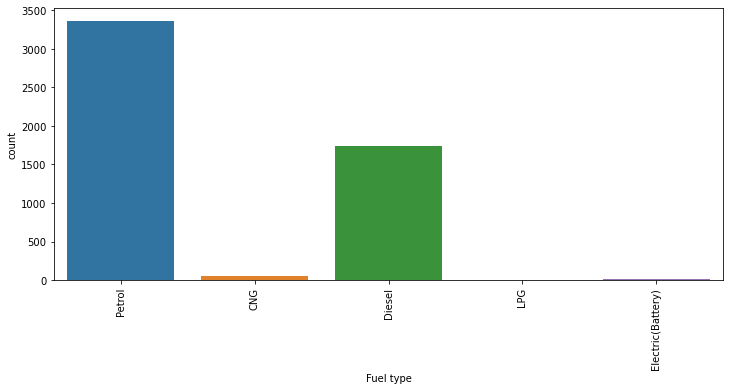

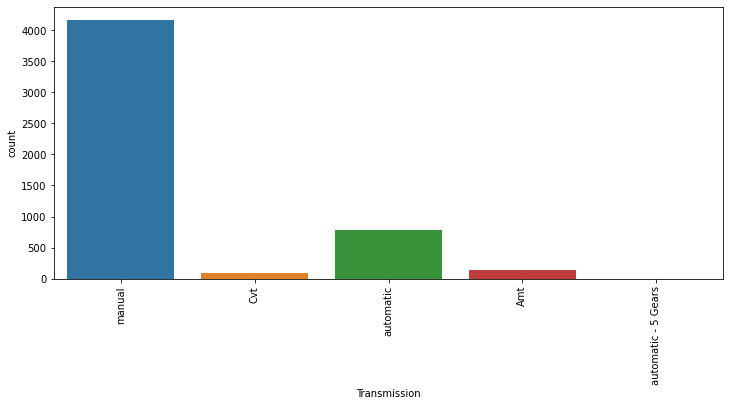

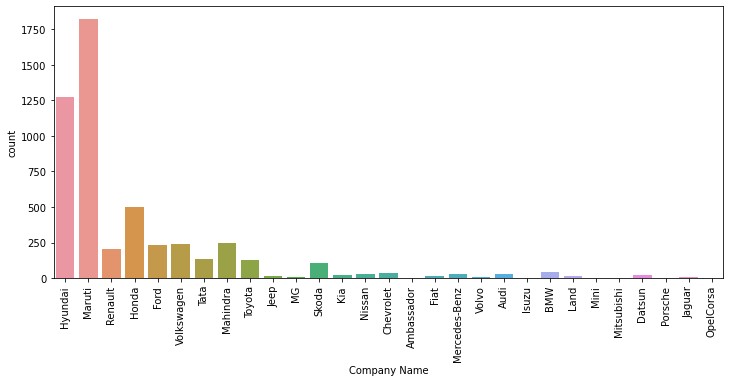

In [99]:
for i in cat_feat[1:]:
    plt.figure(figsize=(12,5))
    sns.countplot(df[i])
    plt.xticks(rotation=90)
    plt.show()

Observations:
- Out of the 5k cars, Maruti suzuki and Hyundai are the most used car companies which has been put up for sale, indicating high penetration in the indian market compared to its rivals.
- Manual Transmission is abundant as the cars tend to be cheaper which makes sense for the indian market
- We have almost equal number of cars available from all the 5 major cities.
- Petrol cars have the highest quantity to be listed for sale, as petrol have an extra benefit compared to Diesel - it can be converted to run on CNG, which is almost 50% cheaper than petrol and diesel and cleaner for the environment.
- Most cars are relatively new with majority belonging to 2014 to 2019 

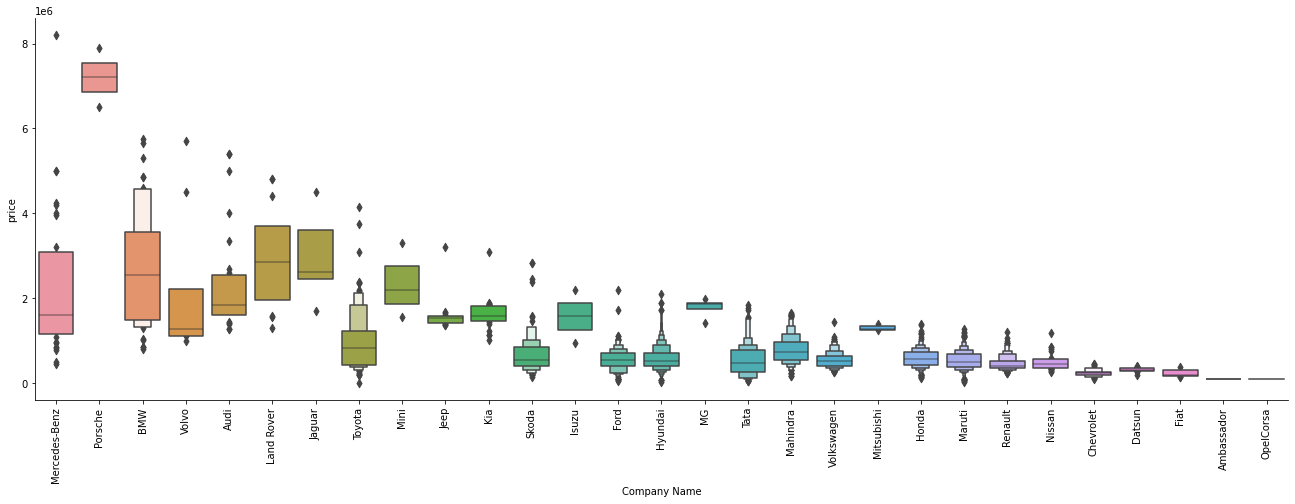

In [113]:
sns.catplot(y = "price", x = "Company Name", data = df.sort_values("price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.xticks(rotation=90)
plt.show()

Observation:
- We can see majority of the companies have outlier prices.
- Luxurious brands will logically be expensive than commercial car brans, like Porsche is the one of the most expensive luxury car company in the world.


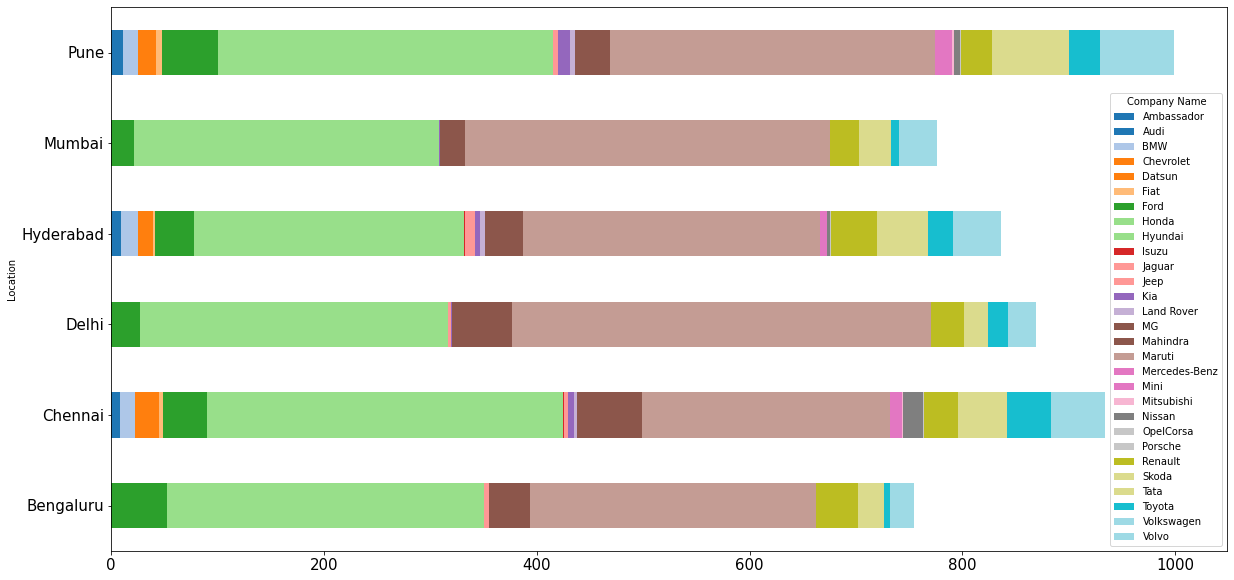

In [138]:
pd.crosstab(df['Location'],df['Company Name']).plot(kind='barh', stacked=True,figsize=(20,10),fontsize=15,colormap="tab20")
plt.show()

Observation:
- Chennai has more hyundai's listed than Maruti's indicating the famous car company in the city.
- Delhi has the largest number of Maruti's listed
- Chennai also tops the list in terms of toyota's listed.

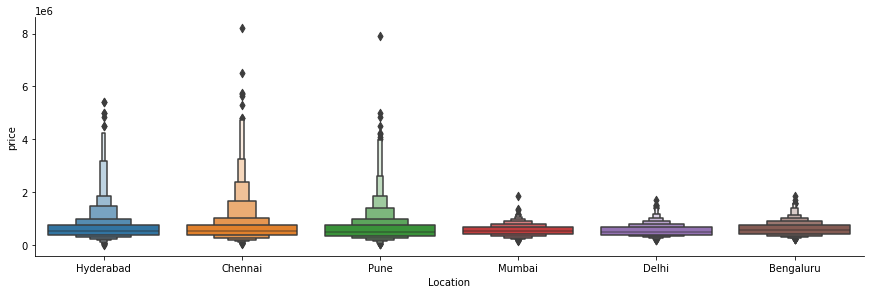

In [143]:
sns.catplot(y = "price", x = "Location", data = df.sort_values("price", ascending = True), kind="boxen", height = 4, aspect = 3)
plt.show()

observation:
- Mumbai, Delhi and Bengaluru have only inexpensive cars listed whereas the other 3 definitely have a lot of expensive cars listed as well.
- All the cities have almost equal average listed price.

In [145]:
df.columns

Index(['name', 'price', 'Location', 'Fuel type', 'Transmission', 'Kms driven',
       'year', 'Company Name'],
      dtype='object')

<AxesSubplot:xlabel='Kms driven', ylabel='price'>

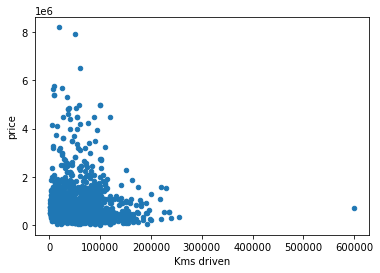

In [153]:
df.plot.scatter(y="price",x="Kms driven")

Observation:
- Lesser driven vehicles will obviously cost more which is what the graph depicts.

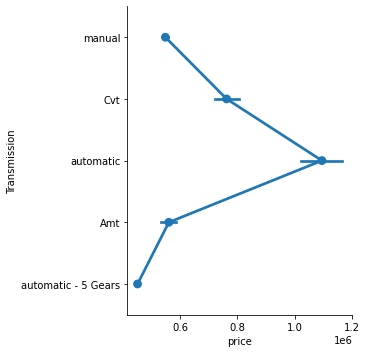

In [163]:
sns.catplot(kind="point",x="price",y="Transmission",data=df)

observation:
- Automatic cars are the most expensive with CVT coming in at second.

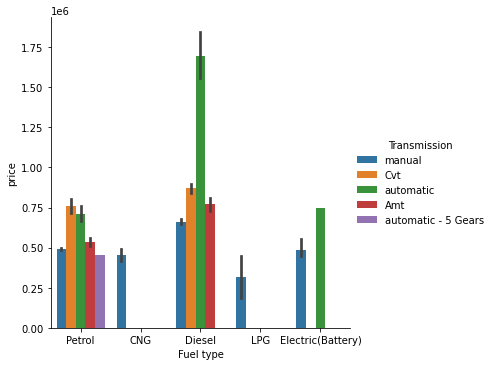

In [169]:
sns.catplot(kind="bar",y="price",x="Fuel type",hue="Transmission",data=df)

Observation:
- Manual cars with LPG are the cheapest combo available
- Automatic and Diesel is the highest priced option listed
- Electric cars have only manual or automatic transmission
- Cvt transmission(manual with no clutch pedal)is the second highest in terms of price in Diesel variant, but cars having Petrol as their fuel type, it's the most expensive type of transmission.


## Data Transformation

In [172]:
num_df=df[num_feat]

### Checking Outliers:

In [173]:
z = np.abs(zscore(num_df))
z.shape

(5169, 2)

In [174]:
threshold = 3
print(np.where(z>3))

(array([3183, 3202, 3206, 3222, 3226, 3231, 3247, 3248, 3250, 3251, 3263,
       3266, 3269, 3275, 3278, 3279, 3290, 3293, 3315, 3317, 3326, 3338,
       3339, 3366, 3400, 3416, 3428, 3429, 3430, 3431, 3432, 3433, 3435,
       3463, 3472, 3565, 3566, 3570, 3577, 3610, 3622, 3636, 3637, 3659,
       3670, 3675, 3692, 3701, 3701, 3726, 3727, 3728, 3779, 3784, 3785,
       3807, 3827, 4059, 4083, 4149, 4150, 4158, 4159, 4170, 4180, 4182,
       4190, 4194, 4197, 4198, 4207, 4208, 4211, 4224, 4227, 4230, 4250,
       4275, 4286, 4298, 4300, 4303, 4305, 4312, 4314, 4321, 4333, 4334,
       4347, 4370, 4386, 4390, 4401, 4402, 4403, 4407, 4410, 4421, 4422,
       4423, 4427, 4448, 4451, 4456, 4588, 4589, 4604, 4611, 4649, 4656,
       4662, 4672, 4677, 4679, 4684, 4693, 4699, 4700, 4702, 4710, 4734,
       4737, 4764, 4765, 4780, 4800, 4811, 4824, 4834, 4860, 4861, 4875,
       4889, 4891, 4974, 4975, 4976, 5003, 5004, 5027, 5041, 5045, 5072,
       5081, 5092, 5123, 5127, 5130], dtype=int64)

In [176]:
df_new=df[(z<3).all(axis=1)]

In [178]:
df_new.shape, df.shape

((5022, 8), (5169, 8))

In [180]:
#### Data Loss %:
((5169-5022)/5169) *100

2.8438769587928032

- Roughly 3% data is lost which is perfectly within standard limit

### Checking Skewness

In [182]:
df_new["Kms driven"].skew()

0.519669211041536

Skewness is absent in the data.
few points though:
- Year is a categorical variable, even though it's of an int datatype
- It's generally recommended to not perform transformation on the target column as it can be misleading for the model. Only outlier removal is done on the target, scaling and skewness reduction is not performed.

<AxesSubplot:xlabel='Kms driven', ylabel='Density'>

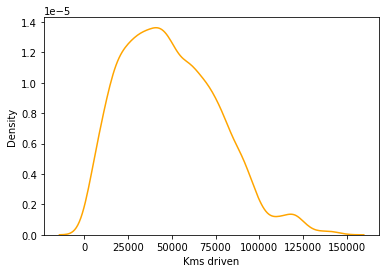

In [184]:
sns.kdeplot(df_new["Kms driven"],color="orange")

In [ ]:
# almost a normal distribution

## Encoding

In [192]:
cat_feat.remove('year')

In [193]:
cat_feat

['name', 'Location', 'Fuel type', 'Transmission', 'Company Name']

In [194]:
le=LabelEncoder()
for row in cat_feat:
    df_new[row] = le.fit_transform(df_new[row])    

In [195]:
df_new.sample(7)

,name,price,Location,Fuel type,Transmission,Kms driven,year,Company Name
1046,91,638178,4,1,4,67098,2018,26
2239,145,401808,5,4,4,53964,2015,7
941,360,475719,4,1,4,33007,2014,6
472,989,703339,2,1,4,76972,2017,15
426,426,760999,2,1,4,47382,2017,16
4474,155,991000,5,4,2,87126,2015,7
4236,245,685000,3,1,4,72911,2014,7


## Splitting dataset:

In [196]:
x=df_new.drop("price",axis=1)
y=df_new["price"]

### Scaling:

In [197]:
sc=StandardScaler()
xs=sc.fit_transform(x)

<AxesSubplot:>

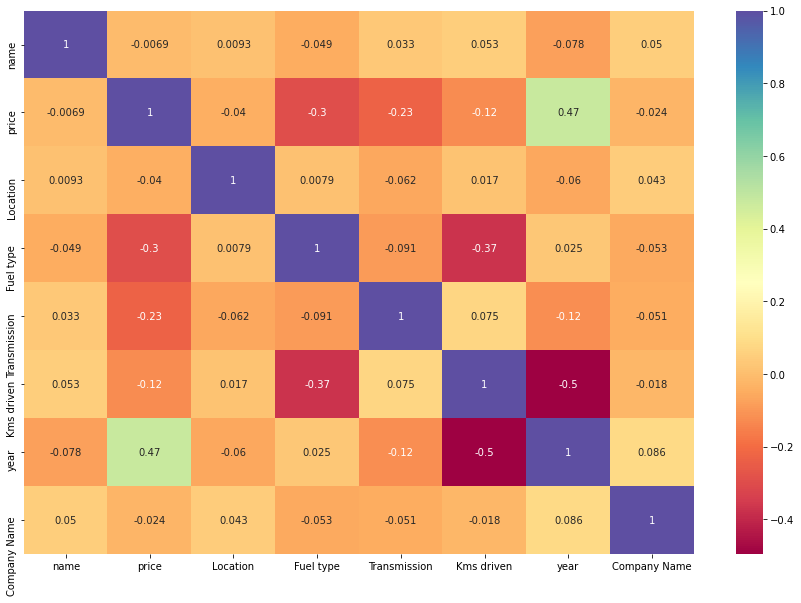

In [198]:
plt.figure(figsize=(15,10))
sns.heatmap(df_new.corr(),annot=True,cmap="Spectral")

- No multicollinearity can be observed as the values are below 0.6

# Models:

In [208]:
for i in range(100,1000):
    X_train,X_test,y_train,y_test=train_test_split(xs,y,test_size=0.2,random_state=i)
    lr=LinearRegression()
    lr.fit(X_train,y_train)
    pred_train=lr.predict(X_train)
    pred_test=lr.predict(X_test)
    if round(r2_score(y_train,pred_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print(f"At random state {i},the training accuracy is:- {r2_score(y_train,pred_train)}")
        print(f"At random state {i},the testing accuracy is:- {r2_score(y_test,pred_test)}")
        print("\n")

At random state 145,the training accuracy is:- 0.3680582979842537
At random state 145,the testing accuracy is:- 0.36778183692884825


At random state 181,the training accuracy is:- 0.3675598612825426
At random state 181,the testing accuracy is:- 0.3682177570172379


At random state 215,the training accuracy is:- 0.36838974630483223
At random state 215,the testing accuracy is:- 0.36822902075258834


At random state 266,the training accuracy is:- 0.3684649094133172
At random state 266,the testing accuracy is:- 0.3681967845205455


At random state 302,the training accuracy is:- 0.36836694347719245
At random state 302,the testing accuracy is:- 0.3680398158479107


At random state 343,the training accuracy is:- 0.3683163778417977
At random state 343,the testing accuracy is:- 0.36821172972425364


At random state 367,the training accuracy is:- 0.367926794389252
At random state 367,the testing accuracy is:- 0.36794724132504564


At random state 372,the training accuracy is:- 0.367408354168380

In [216]:
x_train, x_test,y_train, y_test=train_test_split(xs,y,test_size=.25,random_state=343)

## Model 1: Lasso Regression

In [217]:
from sklearn.linear_model import Lasso

parameters = {'alpha':[.01, .1, 1, 10,100,1000],
              'random_state':list(range(300,400))}
ls = Lasso()
clf = GridSearchCV(ls,parameters)
clf.fit(x_train,y_train)

print(clf.best_params_)

{'alpha': 0.01, 'random_state': 100}


In [229]:
ls = Lasso(alpha=0.01,random_state=100)
ls.fit(x_train,y_train)
ls.score(x_train,y_train)
pred_ls = ls.predict(x_test)

In [230]:
lss = r2_score(y_test,pred_ls)

for k in range(2,10):
    lsscore=cross_val_score(ls,xs,y,cv=k)
    lrcv=lsscore.mean()
    print("At cv= ",k)
    print("Cross Val score : ",lrcv*100)
    print("r2 score is : ",lss*100)
    print("\n")

At cv=  2
Cross Val score :  22.174533772985487
r2 score is :  36.42174688067021


At cv=  3
Cross Val score :  26.302419624055112
r2 score is :  36.42174688067021


At cv=  4
Cross Val score :  27.005029200948314
r2 score is :  36.42174688067021


At cv=  5
Cross Val score :  28.391651540907368
r2 score is :  36.42174688067021


At cv=  6
Cross Val score :  29.117260562646347
r2 score is :  36.42174688067021


At cv=  7
Cross Val score :  30.41682045451317
r2 score is :  36.42174688067021


At cv=  8
Cross Val score :  29.827313453428143
r2 score is :  36.42174688067021


At cv=  9
Cross Val score :  30.413289823790336
r2 score is :  36.42174688067021




At cv=  7
- Cross Val score :  30.416660563742642
- r2 score is :  36.42172238391035

In [224]:
print('MAE:', metrics.mean_absolute_error(y_test, pred_ls))
print('MSE:', metrics.mean_squared_error(y_test, pred_ls))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_ls)))

MAE: 164343.86474122625
MSE: 53627530571.68836
RMSE: 231576.187402091


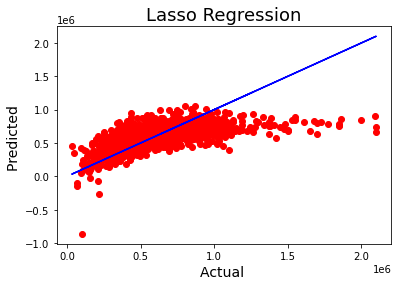

In [225]:
plt.figure(figsize=(6,4))
plt.scatter(x=y_test, y=pred_ls, color='r')
plt.plot(y_test,y_test, color='b')
plt.xlabel('Actual ',fontsize=14)
plt.ylabel('Predicted ',fontsize=14)
plt.title('Lasso Regression',fontsize=18)
plt.show()

## Model 2: Decision Tree Regressor

In [227]:
dtr = DecisionTreeRegressor(criterion='friedman_mse', 
                            max_depth= 8, 
                            max_leaf_nodes= 15, 
                            min_samples_leaf= 100, min_samples_split= 10)
dtr.fit(x_train, y_train)
pred_dtr= dtr.predict(x_test)

In [228]:
dtrr2 = r2_score(y_test,pred_dtr)
for k in range(2,10):
    dtrscore=cross_val_score(dtr,xs,y,cv=k)
    dtrcv=dtrscore.mean()
    print("At cv= ",k)
    print("Cross Val score : ",dtrcv*100)
    print("r2 score is : ",dtrr2*100)
    print("\n")

At cv=  2
Cross Val score :  33.26747694199149
r2 score is :  66.91602137576673


At cv=  3
Cross Val score :  37.676702804324954
r2 score is :  66.91602137576673


At cv=  4
Cross Val score :  50.29419225976759
r2 score is :  66.91602137576673


At cv=  5
Cross Val score :  50.478955500849054
r2 score is :  66.91602137576673


At cv=  6
Cross Val score :  57.107691100804125
r2 score is :  66.91602137576673


At cv=  7
Cross Val score :  56.80788526432089
r2 score is :  66.91602137576673


At cv=  8
Cross Val score :  53.00862728420284
r2 score is :  66.91602137576673


At cv=  9
Cross Val score :  53.79635929446087
r2 score is :  66.91602137576673




At cv=  6
- Cross Val score :  57.107691100804125
- r2 score is :  66.91602137576673

In [231]:
print('MAE:', metrics.mean_absolute_error(y_test, pred_dtr))
print('MSE:', metrics.mean_squared_error(y_test, pred_dtr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_dtr)))

MAE: 93147.8097133758
MSE: 27905947465.540604
RMSE: 167050.7332086292


Text(0, 0.5, 'Y Pred')

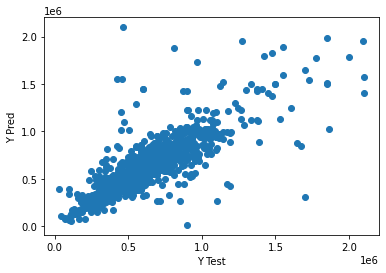

In [232]:
plt.scatter(x=y_test,y=pred_dtr)
plt.xlabel('Y Test')
plt.ylabel('Y Pred')

## Model 3: Random Forest Regressor

In [237]:
rf_reg_params =  { 'max_depth': [5,7,10,12], "criterion": ["squared_error", "absolute_error", "poisson"],
                  'max_features': ['auto', 'log2','sqrt'], 'n_estimators': [250,300,350,200]}
rand_rf_reg = RandomizedSearchCV(RandomForestRegressor(), rf_reg_params)

rand_rf_reg.fit(x_train, y_train)

rf_reg = rand_rf_reg.best_estimator_
# print(rf_reg)
print("Best Estimators for Decision Tree Regression: ", rand_rf_reg.best_params_)
print("best r2 score: ",rand_rf_reg.best_score_)
print("------------------------------------------")

Best Estimators for Decision Tree Regression:  {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'poisson'}
best r2 score:  0.4313301210331514
------------------------------------------


In [234]:
rfr = RandomForestRegressor()
# criterion='poisson', max_depth= 10, max_features="log2",n_estimators=200)
rfr.fit(x_train, y_train)
pred_rfr= rfr.predict(x_test)

In [235]:
rfrr2 = r2_score(y_test,pred_dtr)

for k in range(2,10):
    rfrscore=cross_val_score(rfr,xs,y,cv=k)
    rfrcv=rfrscore.mean()
    print("At cv= ",k)
    print("Cross Val score : ",rfrcv*100)
    print("r2 score is : ",rfrr2*100)
    print("\n")

At cv=  2
Cross Val score :  58.56965108392978
r2 score is :  66.91602137576673


At cv=  3
Cross Val score :  66.21225691008526
r2 score is :  66.91602137576673


At cv=  4
Cross Val score :  71.94726181955497
r2 score is :  66.91602137576673


At cv=  5
Cross Val score :  74.62625839317728
r2 score is :  66.91602137576673


At cv=  6
Cross Val score :  75.63540010179221
r2 score is :  66.91602137576673


At cv=  7
Cross Val score :  76.09381184419757
r2 score is :  66.91602137576673


At cv=  8
Cross Val score :  77.16711569937085
r2 score is :  66.91602137576673




KeyboardInterrupt: 

At cv=  3
- Cross Val score :  66.21225691008526
- r2 score is :  66.91602137576673

In [238]:
print('MAE:', metrics.mean_absolute_error(y_test, pred_rfr))
print('MSE:', metrics.mean_squared_error(y_test, pred_rfr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_rfr)))

MAE: 74629.86048964968
MSE: 15843003619.866734
RMSE: 125868.99387802674


<AxesSubplot:xlabel='price', ylabel='Density'>

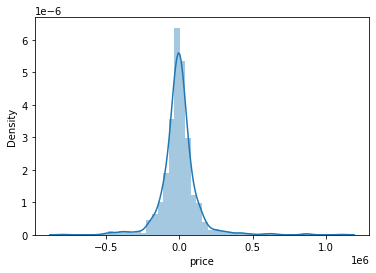

In [241]:
sns.distplot((y_test-pred_rfr),bins=50)


Text(0, 0.5, 'Y Pred')

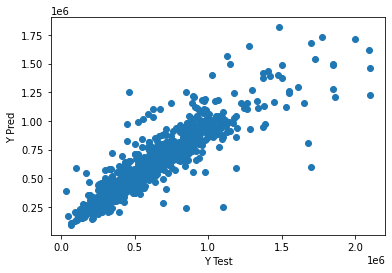

In [242]:
plt.scatter(x=y_test,y=pred_rfr)
plt.xlabel('Y Test')
plt.ylabel('Y Pred')

## Model 4: XGB Regressor

In [243]:
from xgboost import XGBRegressor

In [246]:
xgb_reg_params =  {'booster' : ['gbtree','dart','gblinear'], 'importance_type' : ['gain','split'],'n_estimators' : [100,200,300],'eta' : [0.001, 0.01, 0.1]}
rand_xgb_reg = RandomizedSearchCV(XGBRegressor(), xgb_reg_params)

rand_xgb_reg.fit(x_train, y_train)

xgb_reg = rand_xgb_reg.best_estimator_
# print(rf_reg)
print("Best Estimators for Decision Tree Regression: ", rand_xgb_reg.best_params_)
print("best r2 score: ",rand_xgb_reg.best_score_)
print("------------------------------------------")

Best Estimators for Decision Tree Regression:  {'n_estimators': 300, 'importance_type': 'split', 'eta': 0.1, 'booster': 'gbtree'}
best r2 score:  0.8493897338109322
------------------------------------------


In [247]:
xgb = XGBRegressor(n_estimators= 300, importance_type= 'split', eta=0.1, booster='gbtree')
xgb.fit(x_train,y_train)
xgb.score(x_train,y_train)
pred_xgb = xgb.predict(x_test)

In [248]:
xgbs = r2_score(y_test,pred_xgb)
xgbs

0.8668541041192348

In [254]:
xgbs = r2_score(y_test,pred_xgb)

for k in range(5,9):
    xgbscore=cross_val_score(xgb,xs,y,cv=k)
    xgbcv=xgbscore.mean()
    print("At cv= ",k)
    print("Cross Val score : ",xgbcv*100)
    print("r2 score is : ",xgbs*100)
    print("\n")

At cv=  5
Cross Val score :  80.18164377746565
r2 score is :  86.68541041192348


At cv=  6
Cross Val score :  80.68685167680081
r2 score is :  86.68541041192348


At cv=  7
Cross Val score :  83.45996117921885
r2 score is :  86.68541041192348


At cv=  8
Cross Val score :  82.96916459647099
r2 score is :  86.68541041192348




At cv=  7
- Cross Val score :  83.45996117921885
- r2 score is :  86.68541041192348

In [258]:
print('MAE:', metrics.mean_absolute_error(y_test, pred_xgb))
print('MSE:', metrics.mean_squared_error(y_test, pred_xgb))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_xgb)))

MAE: 63891.28313159335
MSE: 11230699964.784185
RMSE: 105974.99688503976


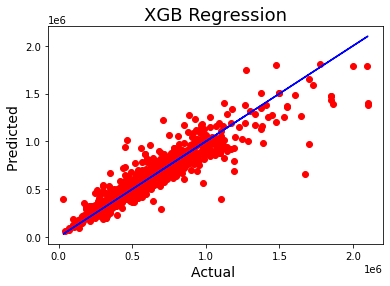

In [259]:
plt.figure(figsize=(6,4))
plt.scatter(x=y_test, y=pred_xgb, color='r')
plt.plot(y_test,y_test, color='b')
plt.xlabel('Actual ',fontsize=14)
plt.ylabel('Predicted ',fontsize=14)
plt.title('XGB Regression',fontsize=18)
plt.show()

<AxesSubplot:xlabel='price', ylabel='Density'>

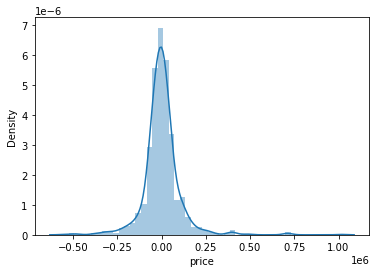

In [261]:
sns.distplot((y_test-pred_xgb),bins=50)


- We can see that XGB reggressor is performing the best as evident from the Cross Val score :  83.45996117921885 and r2 score is :  86.68541041192348

# Saving the model

In [268]:
filename = "used_car_price_pred.pkl"
pickle.dump(xgb,open(filename,'wb'))

In [270]:
h = np.array(y_test)
predicted = np.array(pred_xgb)
df_comp = pd.DataFrame({"original":h, "predicted":predicted},index=range(len(h)))
df_comp

,original,predicted
0,1264499,1.379576e+06
1,299000,2.988018e+05
2,399047,3.876838e+05
3,609426,6.295355e+05
4,901999,8.741569e+05
...,...,...
1251,508432,4.928964e+05
1252,290000,2.824703e+05
1253,1053295,8.841284e+05
1254,559204,5.136549e+05
